In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
import matplotlib.pyplot as plt
from statnlpbook.lm import *
from statnlpbook.util import safe_log as log
import statnlpbook.mt as mt
# util.execute_notebook('word_mt.ipynb')
# matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import tikzmagic

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Word-based Machine Translation

Machine Translation (MT) is one of the canonical NLP applications, and one that nowadays most people are familiar with, primarily through online translation services of the major search engine providers. While there is still some way to go before machines can provide fluent and flawless translations, in particular for more distant language pairs like English and Japanese, progress in this field has been remarkable. 

In this chapter we will illustrate the foundations of this progress, and focus on word-based machine translation models. In such models words are the basic unit of translation. Nowadays the field has mostly moved to phrase and syntax-based approaches (and fully neural methods), but the word-based approach is still important, both from a foundational point of view, and as sub-component in more complex approaches.

## MT as Structured Prediction

Formally we will see MT as the task of translating a _source_ sentence $\source$ to a _target_ sentence $\target$. We can tackle the problem using the [structured prediction recipe](structured_prediction.ipynb): We define a parametrised model $s_\params(\target,\source)$ that measures how well a target  $\target$ sentence matches a source sentence $\source$, learn the parameters $\params$ from training data, and then find

\begin{equation}\label{decode-mt}
\argmax_\target s_\params(\target,\source)
\end{equation}

as translation of $\source$. Different _statistical_ MT approaches, in this view, differ primarily in how $s$ is defined, $\params$ are learned, and how the $\argmax$ is found.

## Noisy Channel Model for MT

Many Word-based MT systems, as well as those based on more advanced representations, rely on a [Noisy Channel](https://www.dropbox.com/s/gfucv538m6anmgd/NoisyChannel.pdf?dl=0) model as choice for the scoring function $s_\params$. In this approach to MT we effectively model the translation process *in reverse*. That is, we assume that a probabilistic process (the speaker's brain) first generates the target sentence $\target$ according to the distribution $\prob(\target)$. Then the target sentence $\target$ is transmitted through a _noisy channel_ $\prob(\source|\target)$ that translates $\target$ into $\source$. 

Hence translation is seen as adding noise to a clean $\target$. This _generative story_ defines a _joint distribution_ over target and source sentences $\prob(\source,\target) = \prob(\target) \prob(\source|\target)$.

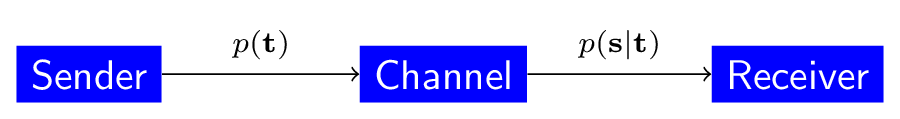

In [2]:
%%tikz
\tikzset{every node/.style={font=\sffamily,white}} 
\node[fill=blue] at (0,0) (a) {Sender}; 
\node[fill=blue] at (3,0) (b) {Channel}; 
\node[fill=blue] at (6,0) (c) {Receiver}; 
\draw[->] (a) -- (b) node [midway,above,font=\scriptsize,black]{$p(\mathbf{t})$}; 
\draw[->] (b) -- (c) node [midway,above,font=\scriptsize,black]{$p(\mathbf{s}|\mathbf{t})$};

We can in turn operate this distribution in the direction we actually care about: to infer a target sentence $\target$ given a source sentence $\source$ we find the _maximum a posteriori_ sentence

\begin{equation}
\label{decode-nc}
\target^* = \argmax_\target \prob(\target | \source) = \argmax_\target \prob(\target) \, \prob(\source | \target). 
\end{equation}

For the structured prediction recipe this means setting 

$$
s_\params(\target,\source) = \prob(\target) \, \prob(\source | \target). 
$$

In the noisy channel approach for MT the distribution $\prob(\target)$ that generates the target sentence is usually referred to as [language model](/template/statnlpbook/01_tasks/01_languagemodels), and the noisy channel is called the _translation model_. As we have discussed language models earlier, in this chapter we focus on the translation model $\prob(\source|\target)$.

## A Naive Baseline Translation Model
The most straightforward translation model translates words one-by-one, in the order of appearance:
$$
\prob_\params^\text{Naive}(\ssource|\starget) = \prod_i^{\length{\source}} \param_{\ssource_i,\starget_i}
$$
where $\param_{\ssource,\starget} $ is the probability of translating $\starget$ as $\ssource$. $\params$ is often referred to as *translation table*.

For many language pairs one can acquire training sets $\train=\left( \left(\source_i,\target_i\right) \right)_{i=1}^n $ of paired source and target sentences. For example, for French and English the [Aligned Hansards](http://www.isi.edu/natural-language/download/hansard/) of the Parliament of Canada can be used. Given such a training set $\train$ we can learn the parameters $\params$ using the [Maximum Likelhood estimator](/template/statnlpbook/02_methods/0x_mle). In the case of our Naive model this amounts to setting
$$
\param_{\ssource,\starget} = \frac{\counts{\train}{s,t}}{\counts{\train}{t}} 
$$
Here $\counts{\train}{s,t}$ is the number of times we see target word $t$ translated as source word $s$, and $\counts{\train}{t}$ the number of times we the target word $t$ in total.

### Training the Naive Model
Let us prepare some toy data to show how to train this naive model.

In [3]:
train_raw = [
    ("the house is small", "das Haus ist klein"),
    ("the house is small", "klein ist das Haus"),
    ("a man is tall", "ein Mann ist groß"),
    ("my house is small", "klein ist mein Haus")
]
train = [(t.split(" "), s.split(" ")) for t,s in train_raw]
train

[(['the', 'house', 'is', 'small'], ['das', 'Haus', 'ist', 'klein']),
 (['the', 'house', 'is', 'small'], ['klein', 'ist', 'das', 'Haus']),
 (['a', 'man', 'is', 'tall'], ['ein', 'Mann', 'ist', 'groß']),
 (['my', 'house', 'is', 'small'], ['klein', 'ist', 'mein', 'Haus'])]

Notice how we transformed raw strings into tokenised sentences via `split`. This dataset can be used to train the naive model as follows. 

In [4]:
from collections import defaultdict 
def learn_naive_model(data):
    """
    Trains a naive per-word-translation model.
    Args:
        data: list of (target,source) pairs
    Returns:
        dictionary from (source,target) word pair to probability.
    """
    norm = defaultdict(float)
    counts = defaultdict(float)
    for target, source in data:
        for i in range(0, len(target)):
            norm[target[i]] += 1.0
            counts[(source[i],target[i])] += 1.0
    result = {}
    for (source,target),score in counts.items():
        result[(source,target)] = score / norm[target]
    return result

Let us train on the toy dataset:

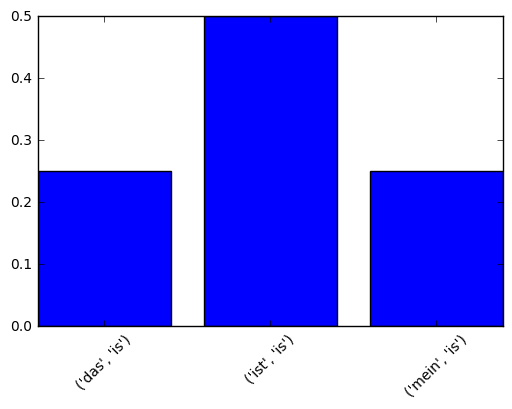

In [5]:
table = learn_naive_model(train)
def plot_table_for_target(table, target):
    source_for_is, scores = zip(*[item for item in sorted(table.items()) if item[0][1] == target])
    util.plot_bar_graph(scores, source_for_is, rotation=45, align='center')
plot_table_for_target(table, "is")

### Decoding with the Naive Model

*Decoding* in MT is the task of finding the solution to equation $\ref{decode-mt}$. That is, we need to find that target sentence with maximum a posteriori probability, which is equivalent to finding the target sentence with maximum likelihood as per equation $\ref{decode-nc}$. The phrase "decoding" relates to the noisy channel analogy. Somebody generated a message, the channel encodes (translates) this message and the receiver needs to find out what the original message was.   

In the naive model decoding is trivial if we assume a unigram language model. We need to choose, for each source word, the target word with maximal product of translation and language model probability. For more complex models this is not sufficient, and we discuss a more powerful decoding method later.


In [6]:
def decode(source_sent, model, lm):
    """
    Decodes using the naive model. Translates each source token in isolation and appends the results.
    Args:
        source_sent: the source sentence as a list of tokens.
        model: the naive model, a dictionary from (source,target) to probabilities.
        lm: a uniform language model as defined in the language_models chapter.
    Returns:
        a list of target tokens. 
    """
    source_to_targets = defaultdict(list)
    for (source,target),prob in model.items():
        source_to_targets[source] += [(target,prob)]
    result = []
    for tok in source_sent:
        candidates = source_to_targets[tok]
        multiplied_with_lm = [(target,prob * lm.probability(target)) for target, prob in candidates]
        target = max(multiplied_with_lm, key=lambda t: t[1])
        result.append(target[0])
    return result

source = train[1][1]
lm = UniformLM(set([target for _, target in table.keys()]))
target = decode(source, table, lm)
target

['my', 'house', 'the', 'small']

The naive model is broken in several ways. Most severely, it ignores the fact that word order can differ and still yield (roughly) the same meaning.   

## IBM Model 2
The IBM Model 2 is one of the most influential translation models, even though these days it is only indirectly used in actual MT systems, for example to initialize translation and alignment models. As IBM Model 2 can be understood as generalization of IBM Model 1, we omit the latter for now and briefly illustrate it afterward our introduction of Model 2. Notice that parts of these exposition are based on the excellent [lecture notes on IBM Model 1 and 2](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/ibm12.pdf) of Mike Collins.

### Alignment
The core difference of Model 2 to our naive baseline model is the introduction of _latent_ auxiliary variables: the word to word _alignment_ $\aligns$ between words. In particular, we introduce a variable $a_i \in [0 \ldots \length{\target}]$ for each source sentence index $i \in [1 \ldots \length{\source}]$. The word alignment $a_i = j $ means that the source word at token $i$ is _aligned_ with the target word at index $j$. 

Notice that $\align_i$ can be $0$. This corresponds to a imaginary _NULL_ token $\starget_0$ in the target sentence and allows source words to be omitted in an alignment. 

Below you see a simple example of an alignment.


In [7]:
import statnlpbook.word_mt as word_mt
alignments=word_mt.Alignment("NULL the house is small".split(" "),
                             "klein ist das Haus".split(" "),
                             [(1,2),(2,3),(3,1),(4,0)])
alignments

An example where source words have been dropped, as indicated via the `NULL` alignment, can be seen below. Here the Japanese case marker が is dropped in the English translation.

In [8]:
word_mt.Alignment("NULL I like music".split(" "),
                  "音楽 が 好き".split(" "),
                  [(0,1),(2,2),(3,0)])

IBM Model 2 defines a conditional distribution $\prob(\source,\aligns|\target)$ over both the source sentence $\source$ and its alignment $\aligns$ to the target sentence $\target$. Such a model can be used as translation model $\prob(\source|\target)$, as defined above, by marginalizing out the alignment 

$$
\prob(\source|\target) = \sum_{\aligns} \prob(\source,\aligns|\target).
$$

### Model Parametrization


IBM Model 2 defines its conditional distribution over source and alignments using two sets of parameters $\params=(\balpha,\bbeta)$. Here $\alpha(\ssource|\starget)$ is a parameter defining the probability of translation target word $\starget$ into source word $\ssource$, and $\beta(j|i,l_\starget,l_\ssource)$ a parameter that defines the probability of aligning the source word at token $i$ with the target word at token $j$, conditioned on the length $l_\starget$ of the target sentence, and the length $l_\ssource$ of the source sentence. In addition, Model 2 assigns a uniform probabilitity $\epsilon$ over source sentences lengths.  

With the above parameters, IBM Model 2 defines a conditional distribution over source sentences and alignments, conditioned on a target sentence _and a desired source sentence length_ $l_\ssource$: <span class="summary">Model 2 defines a conditional distribution over source sentences and alignments:

\begin{equation}
\label{ibm2}
  p_\params^\text{IBM2}(\ssource_1 \ldots \ssource_{l_\ssource},\align_1 \ldots \align_{l_\ssource}|\starget_1 \ldots \starget_{l_\starget}) = \epsilon \prod_i^{l_\ssource} \alpha(\ssource_i|\starget_{a_i}) \beta(a_i|i,l_\starget,l_\ssource)
\end{equation}

## Training IBM Model 2 with the EM Algorithm

Training IBM Model 2 is less straightforward than training our naive baseline. The main reason is the lack of _gold alignments_ in the training data. That is, while we can quite easily find, or heuristically construct, _sentence-aligned_ corpora like our toy dataset, we generally do not have _word aligned_ sentences.

To overcome this problem, IBM Model can be trained using the Expectation Maximization (EM) Algorithm, a general recipe when learning with partially observed data&mdash;in our case the data is partially observed because we observe the source and target sentences, but not their alignments. The EM algorithm maximizes a lower bound of the log-likelihood of the data. The log-likelihood of the data is:

$$
  \sum_{(\target_i,\source_i) \in \train} \log p_\params^\text{IBM2}(\source_i|\target_i) =  \sum_{(\target_i,\source_i) \in \train} \log \sum_{\aligns}  p_\params^\text{IBM2}(\source_i,\aligns|\target_i) 
$$

EM can be be seen as [block coordinate descent](https://www.dropbox.com/s/vrsefe3m57bxpgv/EMforTM.pdf?dl=0) on this bound.


The EM algorithm is an iterative method that iterates between two steps, the E-step (Expectation) and the M-Step (Maximization), until convergence. For the case of IBM Model 2 the E and M steps are instantiated as follows: 

  * **E-Step**: given a current set of parameters $\params$, calculate the **expectations** $\pi$ of the latent alignment variables under the model $p_\params^\text{IBM2}$ &mdash; this amounts to estimating a _soft alignment_ for each sentence.    
  * **M-Step**: Given training set of soft alignments $\pi$, find new parameters $\params$ that **maximize** the log likelihood of this (weighted) training set. This amounts to soft counting. 

### E-Step
<div class="book-start"></div>

The E-Step calculates the distribution

$$
\pi(\aligns|\source,\target) = p_\params^\text{IBM2}(\aligns|\source,\target)
$$

for the current parameters $\params$. For Model 2 this distribution has a very simple form:

$$
\pi(\aligns|\source,\target) = \prod_i^{l_{\ssource}} \pi(a_i|\source,\target,i) = \prod_i^{l_{\ssource}} 
  \frac
    {\alpha(\ssource_i|\starget_{a_i}) \beta(a_i|i,l_\starget,l_\ssource)}
    {\sum_j^{l_{\starget}} \alpha(\ssource_i|\starget_j) \beta(j|i,l_\starget,l_\ssource) }
$$

Importantly, the distribution over alignments *factorizes* in a per-source-token fashion, and hence we only need to calculate, for each source token $i$ and each possible alignment $a_i$, the probability (or expectation) $\pi(a_i|\source,\target,i)$.

Before we look at the implementation of this algorithm we will set up the training data to be compatible with our formulation. This involves introducing a 'NULL' token to each target sentence to allow source tokens to remain unaligned. 

In [9]:
train_model_2_raw = [
  ("NULL the house is small" , "klein ist das Haus"),
  ("NULL a man is tall" , "groß ist ein Mann"),
  ("NULL my house is small" , "klein ist mein Haus"),
  ("NULL the building is big" , "groß ist das Gebäude"),
  ("NULL the building is long" , "lang ist das Gebäude")
]
train_model_2 =  [(t.split(" "), s.split(" ")) for t,s in train_model_2_raw]
train_model_2

[(['NULL', 'the', 'house', 'is', 'small'], ['klein', 'ist', 'das', 'Haus']),
 (['NULL', 'a', 'man', 'is', 'tall'], ['groß', 'ist', 'ein', 'Mann']),
 (['NULL', 'my', 'house', 'is', 'small'], ['klein', 'ist', 'mein', 'Haus']),
 (['NULL', 'the', 'building', 'is', 'big'], ['groß', 'ist', 'das', 'Gebäude']),
 (['NULL', 'the', 'building', 'is', 'long'],
  ['lang', 'ist', 'das', 'Gebäude'])]

We can now implement the E-Step. First we introduce a data structure to represent the IBM Model 2. 

In [ ]:
class IBMModel2:
    """
    A representation of IBM Model 2 with alpha and beta parameters.
    """
    def __init__(self, alpha, beta):
        """
        Create a new IBM Model 2 instance.
        Params:
            alpha: a dictionary that from pairs (s,t) of source and target words to probilities.
            beta: a dictionary that maps from tuples (ti,si,lt,ls) of target index, source index, target length
            and source length to the probability p(ti|si,lt,ls).
        """
        self.alpha = alpha
        self.beta = beta

We also need a way to normalise a vector of real values to sum up to 1.

In [ ]:
def norm_scores(scores):
    """
    Normalises the alignment scores to sum up to one.
    Params:
        a list of unnormalised scores.
    Returns:
        a scaled version of the input list such that its elements sum up to 1.
    """
    norm = sum(scores)
    return [s/norm for s in scores]

The E-Step can now be implemented as follows.

In [10]:
def e_step(model, data):
    """
    Perform the E-Step of the EM algorithm.
    Params:
        model: An IBMModel2 instance.
        data: a list of (t,s) pairs of target and source sentences.
    Returns:
        a list of alignment matrices, one for each instance in `data`. An alignment matrix is a list of lists, one list
        per source token, and the float numbers in each list correspond to the alignment probabilities for each token with
        respect to the source token.
    """
    all_alignments = []
    for target,source in data:
        def score(si, ti):
            return model.alpha[source[si],target[ti]] * model.beta[ti,si, len(target),len(source)]
        result = []
        for si in range(0, len(source)):
            scores = norm_scores([score(si,ti) for ti in range(0, len(target))])
            result.append(scores)
        all_alignments.append(result)
    return all_alignments

Let us run this code using a simple initial model. 

In [11]:
source_vocab = set([tok for _,s in train_model_2 for tok in s])
target_vocab = set([tok for t,_ in train_model_2 for tok in t])

max_length = 5
alpha, beta = {}, {}
for s in source_vocab:
    for t in target_vocab:
        alpha[s,t] = 1.0 / len(source_vocab)
for ti in range(0, max_length):
    for si in range(0, max_length):
        for lt in range(1, max_length+1):
            for ls in range(1, max_length+1):
                beta[ti,si,lt,ls] = 1.0 / lt
                
init_model = IBMModel2(alpha,beta)
align_matrices = e_step(init_model, train_model_2)
word_mt.Alignment.from_matrix(align_matrices[0], train_model_2[0][1], train_model_2[0][0])

You can play around with the initialization of $\balpha$ to see how the alignments react to changes of the word-to-word translation probabilities.

### M-Step

The M-Step optimizes a *weighted* or *expected* version of the log-likelihood of the data, using the distribution $\pi$ from the last E-Step:

$$
  \params^* = \argmax_\params \sum_{(\target,\source) \in \train} \sum_\aligns \pi(\aligns|\target,\source) \log \prob _\params^\text{IBM2}(\source,\aligns|\target)
$$

The summing over hidden alignments seems daunting, but because $\pi$ factorizes as we discussed above, we again have a simple closed-form solution:

$$
  \alpha(\ssource|\starget) = \frac
    {\sum_{(\target,\source)}\sum_i^{l_\source} \sum_j^{l_\target} \pi(j|i) \delta(\ssource,\ssource_i) \delta(\starget,\starget_j) }
    {\sum_{(\target,\source)} \sum_j^{l_\target} \delta(\starget,\starget_j) }
$$

where $\delta(x,y)$ is 1 if $x=y$ and 0 otherwise. The updates for $\beta$ are similar. 

Let us implement the M-Step now. In this step we estimate parameters $\params$ from a given set of (soft) alignments $\aligns$. 


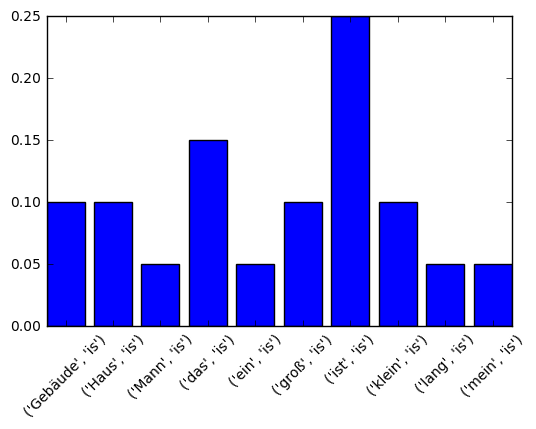

In [25]:
def m_step(aligns, data):
    """
    Perform the M-step for IBM Model 2.
    Params:
        aligns: a list of alignments, one for each sentence in the training data. An alignment is represented
        as a list of vectors, one vector per source, that represents the distribution over aligned target tokens.
        data* a list of (target, source) sentence pairs.
    
    Return:
        an IBMModel2 object with transition and distortion tables estimated via soft counting on the 
        assignments. 
    """
    alpha = defaultdict(float)
    alpha_norm = defaultdict(float)
    beta = defaultdict(float)
    beta_norm = defaultdict(float)
    for pi, (t,s) in zip(aligns, data):
        for ti in range(0, len(t)):
            for si in range(0, len(s)):
                prob = pi[si][ti]
                alpha[s[si], t[ti]] += prob
                alpha_norm[t[ti]] += prob
                beta[ti,si,len(t),len(s)] += prob
                beta_norm[si,len(t),len(s)] += prob
    for key in alpha.keys():
        alpha[key] /= alpha_norm[key[1]]
    for key in beta.keys():
        beta[key] /= beta_norm[key[1:]]
    return IBMModel2(alpha,beta)
theta1 = m_step(align_matrices, train_model_2)    
plot_table_for_target(theta1.alpha, "is")

Notice that the algorithm already figured out that "is" is most likely translated to "ist". This is because it is (softly) aligned with "is" in every sentence, whereas other German words only appear in a subset of the sentences.

### Initialization (IBM Model 1)
We could already iteratively call `eStep` and `mStep` until convergence. However, a crucial question is how to initialize the model parameters for the first call to 'eStep'. So far we used a uniform initialization, but given that the EM algorithm's results usually depend significantly on initialization, using a more informed starting point can be useful. 

A common way to initialize EM for IBM Model 2 training is to first train the so called IBM Model 1 using EM. This model really is an instantiation of Model 2 with a specific and **fixed** alignment parameter set $\bbeta$. Instead of estimating $\bbeta$ it is set to assign uniform probability to all target tokens with respect to a given length: 

$$
  \beta(a_i|i,l_\starget,l_\ssource) = \frac{1}{l_\starget + 1}
$$

After training the parameters $\params$ of Model 1 can be used to initialize EM for Model 2.  

Training Model 1 using EM could have the same initialization problem. Fortunately it turns out that with $\bbeta$ fixed in this way it can be shown, under mild conditions, that EM will converge to a global optimum, making IBM Model 1 robust to choices of initialization.

Let us train IBM Model 1 now. This amounts to using our previous `eStep` and `mStep` methods, initializing $\bbeta$ as above and not updating it during `mStep`. To measure the process of the algorithm we use the change between alignment vectors between consecutive iterations

In [ ]:
def measure_change(alignments1, alignments2):
    """
    Measure the difference between two alignmetns
    Params:
        alignments1: a list of alignments (lists of alignment vectors)
        alignments2: another list of alignments, for the same sentences
    Returns:
        The total absolute change between both lists of alignments.
    """
    total_change = 0.0
    norm = 0.0
    for a1,a2 in zip(alignments1, alignments2):
        for t1, t2 in zip(a1,a2):
            for s1, s2 in zip(t1,t2):
                total_change += abs(s1 - s2)
                norm += 1.0
    return total_change / norm

EM for IBM1 model amounts to the following algorithm. Notice how we reset the $\beta$ part of the model in each step to be uniform again (as our M-step implementation had change it). 

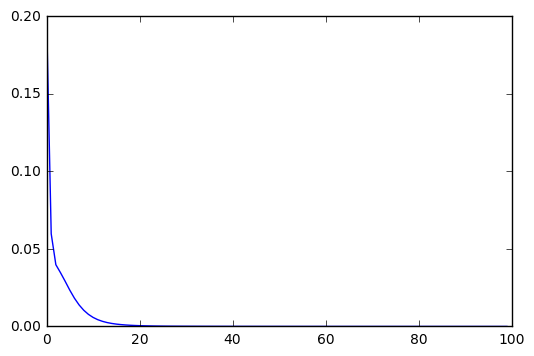

In [28]:
def em_model1(init_model, data, iterations):
    """
    Estimate IBM Model 1 parameters from data.
    Params:
        init_model: the initial model.
        data: (target,source) sentence pairs
        iterations: number of iterations.
    Return:
        Trained IBM Model 1.
    """
    model = init_model
    alignments = []
    for t,s in data:
        alignments.append([[0.0 for _ in s] for _ in t]) 
    results_for_iterations = []
    for _ in range(0, iterations):
        old = alignments
        alignments = e_step(model, data)
        tmp_model = m_step(alignments, data)
        model = IBMModel2(tmp_model.alpha, init_model.beta)
        results_for_iterations.append((alignments, model, measure_change(old,alignments)))
    return results_for_iterations

# measure_change(align_matrices, align_matrices)    
ibm1_iterations = em_model1(init_model, train_model_2, 100)
plt.plot(range(0,len(ibm1_iterations)), [change for _, _, change in ibm1_iterations])

Let us have a look at the translation table.

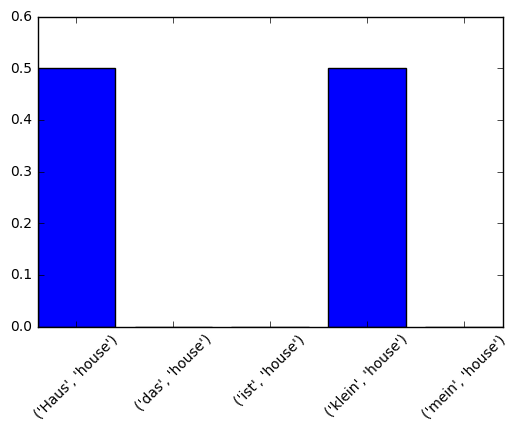

In [14]:
plot_table_for_target(ibm1_iterations[-1][1].alpha, "house")

We can also inspect the alignments generated during EM.

In [15]:
word_mt.Alignment.from_matrix(ibm1_iterations[-1][0][0],train_model_2[0][1], train_model_2[0][0])

### Training IBM Model 2
Now that we have a reasonable initial model we can use it to initialize EM for IBM Model 2. Here is the EM code in full.


In [16]:
def em_model2(init_model, data, iterations):
    """
    Estimate IBM Model 2 parameters from data.
    Params:
        init_model: the initial model.
        data: (target,source) sentence pairs
        iterations: number of iterations.
    Return:
        Trained IBM Model 2.
    """    
    model = init_model
    alignments = []
    for t,s in data:
        alignments.append([[0.0 for _ in s] for _ in t]) 
    results_for_iterations = []
    for _ in range(0, iterations):
        old = alignments
        alignments = e_step(model, data)
        model = m_step(alignments, data)
        results_for_iterations.append((alignments, model, measure_change(old,alignments)))
    return results_for_iterations

Initializing with the IBM Model 1 result gives us: 

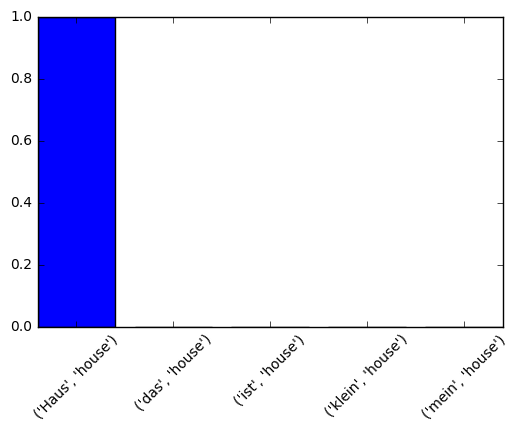

In [17]:
ibm1 = ibm1_iterations[-1][1]
ibm2_iterations = em_model2(ibm1, train_model_2, 100)
ibm2 = ibm2_iterations[-1][1]
plot_table_for_target(ibm2.alpha, "house")

For alignments we get:

In [18]:
word_mt.Alignment.from_matrix(ibm2_iterations[-1][0][0],
                              train_model_2[0][1], train_model_2[0][0])

Let us look at the distortion probabilities for a given source position and source and target lengths.

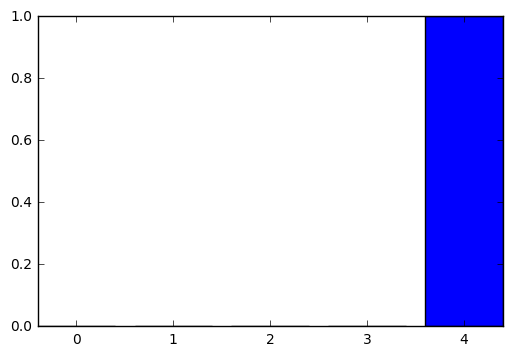

In [19]:
def distort(si):
    return [ibm2.beta[ti,si,5,4] for ti in range(0,5)]
util.plot_bar_graph(distort(0),range(0,5))

### Decoding for IBM Model 2

Decoding IBM Model 2 requires us to  solve the argmax problem in equation $\ref{decode-nc}$, this time using the conditional probability from equation $\ref{ibm2}$ with the hidden alignments marginalized out:

\begin{equation}
  \argmax_{\target} \prob(\target) p_\params^\text{IBM2}(\source | \target) = 
  \argmax_{\target} \prob(\target) \sum_{\aligns} p_\params^\text{IBM2}(\source,\aligns | \target)
\end{equation}

Recall that $\prob(\target)$ is the language model. This nested argmax and sum is generally computationally very hard (see [Park and Darwiche](http://arxiv.org/pdf/1107.0024.pdf)), and often replaced with the simpler problem of finding a combination of best target sequence and corresponding alignment.   

\begin{equation}
  \argmax_{\target,\aligns} \prob(\target) p_\params^\text{IBM2}(\source,\aligns | \target)
\end{equation}

As it turns out for IBM Model 2 the sum can be efficiently calculated, and [Wang and Waibel](http://aclweb.org/anthology/P/P97/P97-1047.pdf) show a stack based decoder that does take this into account. 

<div class="newslide"></div>
However, both for simplicity of exposition and because for most real-world models this marginalization is not possible, we present a decoder that searches over both target and alignment. To simplify the algorithm further we assume that target and source sentences have to have them same length. Of course this is a major restriction, and it is not necessary, but makes the algorithm easier to explain while maintaining the core mechanism. Here we only show only the Python code and refer the reader to our [slides](https://www.dropbox.com/s/p495n19h5rtk3uf/IBM-decoding.pdf?dl=0) for an illustration of how stack and beam based decoders work. 

In [23]:
class Hypothesis:
    """
    A Hypothesis represents a partial translation and its (log) score under the model. 
    """
    def __init__(self, target, align, remaining, score, parent = None, source=None):
        """
        Create a new hypothesis. 
        Params:
            target: the list of target words built so far.
            align: a list of source indices corresponding to the target list.
            remaining: a set of source token indices, indicating which source tokens still need to be translated.
            score: the log probability of the translation so far.
            parent: the previous hypothesis that was extended to create this one. For the root hypothesis
                this should be `None.
            source: the full source sentence. Can be `None` if the parent is not not `None`. 
        
        """
        self.target = target
        self.align = align
        self.remaining = remaining
        self.score = score
        self.parent = parent
        self.source = parent.source if source is None else source
    def __str__(self):
        """
        Returns a string representation of the hypothesis.
        """
        return "({},{},{},{},{})".format(self.target, self.align, self.remaining, self.score, self.parent)
    
def decode_model_2(tm, lm, source, beam_size):
    """
    Decode using IBM Model 2.
    Params:
        tm: an IBM model 2.
        lm: an LanguageModel instance. 
        source: the source sentence.
        beam_size: the size of the beam.
    Returns:
        A list of beams, which itself are lists of hypotheses, with one beam per decoding step. The last
        element of the list is the beam of the last decoding step.
    """
    target_length = len(source) + 1
    def score(hyp, new_target, source_index):
        """
        Calculates the score of appending the target word `new_target` to the hypothesis `hyp` aligned
        with source index `source_index`.
        Params:
            hyp: the hypothesis to add a target to.
            new_target: the new target word to add to the list of target words in `hyp.target`.
            source_index: the index of the source word that is aligned with the new target word.
        Returns:
            the log probability of extending the hypothesis by the new target word.
        """
        lm_prob = log(lm.probability(new_target, *hyp.target))
        tm_prob = log(tm.alpha[source[source_index],new_target]) + \
                  log(tm.beta[len(hyp.target), source_index, target_length, len(source)])
        return lm_prob + tm_prob
    def append(hyp):
        """
        Expand the given hypothesis to create several new hypotheses: one for each possible remaining 
        source word and each way of translating it.
        Params:
            hyp: the hypothesis to expand.
        Returns:
            A list of expanded hypotheses.
        """
        return [Hypothesis(hyp.target + [target_word], 
                           hyp.align + [(source_index, len(hyp.target))],
                           {r for r in hyp.remaining if r != source_index},
                           hyp.score + score(hyp, target_word, source_index),
                           hyp) 
                for source_index in hyp.remaining
                for target_word in lm.vocab]
    # Create the initial beam
    beam = [Hypothesis(['NULL'], [], set(range(0,len(source))), 0.0, None, source)]
    history = [beam]
    while len(beam[0].remaining) > 0:
        # create all possible new hypotheses by expanding all elements in each of the current beams.
        with_new_target = {new_hyp 
                           for hyp in beam 
                           for new_hyp in append(hyp)  }
        # sort the new hypotheses and keep only the top `beam_size` ones.
        beam = sorted(with_new_target, key=lambda h: -h.score)[:beam_size]
        # Remember this beam for future visualisations.
        history.append(beam)
    return history

Let us test this decoder on a simple sentence, using a uniform language model.

In [24]:
source = ["groß", "ist", "ein", "Mann"]
target_vocab = {tok for target, _ in train_model_2 for tok in target}
lm = UniformLM({w for w in target_vocab if w != 'NULL'})
hist = decode_model_2(ibm2, lm, source, 2)
mt.render_history(hist)

NULL,groß ist ein Mann,4,0.0
NULL man,groß ist ein _,3,-inf
NULL a,groß ist _ Mann,3,-2.3978952727983707
NULL man building,groß _ ein _,2,-inf
NULL a man,groß ist _ _,2,-4.795790545596741
NULL man building tall,groß _ _ _,1,-inf
NULL a man is,groß _ _ _,1,-7.886832998955057
NULL a man is tall,_ _ _ _,0,-10.284728271753428
NULL a man is big,_ _ _ _,0,-10.284728271753428


There are currently two contenders for the most likely translation. This is because the translation model is uncertain about the translation of "groß" which can be "tall" in the context of the height of humans, and "big" in most other settings. To avoid this uncertainty we can use a language model to capture the fact that "man is big" is a little less likely than "man is tall".

In [22]:
lm_train = [tok for t,_ in train_model_2 for tok in t]
lm2 = LaplaceLM(NGramLM(lm_train, 3),0.1)
hist2 = decode_model_2(ibm2, lm2, source, 2)
mt.render_history(hist2)

NULL,groß ist ein Mann,4,0.0
NULL house,_ ist ein Mann,3,-inf
NULL a,groß ist _ Mann,3,-2.4849066497880004
NULL house NULL,_ ist ein _,2,-inf
NULL a man,groß ist _ _,2,-3.1780538303479458
NULL a man NULL,groß _ _ _,1,-6.962243464266207
NULL a man is,groß _ _ _,1,-4.564348191467836
NULL a man is big,_ _ _ _,0,-7.655390644826152
NULL a man is tall,_ _ _ _,0,-5.2574953720277815


Note that "a man is tall" is also more likely in the [Google N-grams corpus](https://books.google.com/ngrams/graph?content=a+man+is+tall%2C+a+man+is+big&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=&direct_url=t1%3B%2Ca%20man%20is%20tall%3B%2Cc0%3B.t1%3B%2Ca%20man%20is%20big%3B%2Cc0).

## Summary
There are a few high level messages to take away from this chapter.

* MT is an instance structured prediction recipe
* The noisy channel is one modeling framework
* word-based MT is foundation and blue print for more complex models
* Training with EM
* NLP Tricks: 
    * introducing latent alignment variables to simplify problem
    * decoding with Beams

## Background Material
* [Lecture notes on IBM Model 1 and 2](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/ibm12.pdf) of Mike Collins.  
* Jurafsky & Martin, Speech and Language Processing: 
    * Chapter 26, Machine Translation.
    * Chapter 6, EM Algorithm
* Brown et al., [The Mathematics of Statistical Machine Translation: Parameter Estimation](http://www.aclweb.org/anthology/J93-2003)